<a href="https://colab.research.google.com/github/ptmhoang97/keras/blob/main/convolutional_layer_RGB_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source:

https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
from numpy import expand_dims
import numpy as np

# Download image

In [2]:
import io

from PIL import Image  # https://pillow.readthedocs.io/en/4.3.x/
import requests  # http://docs.python-requests.org/en/master/


# example image url: https://m.media-amazon.com/images/S/aplus-media/vc/6a9569ab-cb8e-46d9-8aea-a7022e58c74a.jpg
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

In [3]:
url = "https://raw.githubusercontent.com/ptmhoang97/keras/main/bird.jpg"
download_image(url,"/content/bird.jpg")

Image downloaded from url: https://raw.githubusercontent.com/ptmhoang97/keras/main/bird.jpg and saved to: /content/bird.jpg.


# Feature extraction (single convolutional layer)
This part will show weight of filter and output image after processed.

1. Load image

In [87]:
img = load_img('/content/bird.jpg', target_size=(224, 224))

2. Create model with single convolutional layer

In [88]:
num_filter = 3
model = models.Sequential()
model.add(layers.Conv2D(num_filter, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 222, 222, 3)       84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


3. Get convolutional layer of model

In [89]:
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

#print(filters)
#print(biases)

conv2d_22 (3, 3, 3, 3)


4. Show weight of filter (kernel)

(3, 3, 3, 3)
(3, 3, 3)
(3, 3)
(3, 3)
(3, 3)


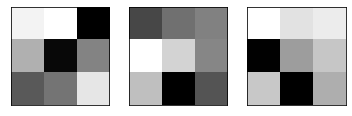

In [90]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)
# plot first few filters
n_filters, ix = 1, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    print(f.shape)
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(2, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        print(f[:, :, j].shape)
        ix += 1

# "plt.imshow" need 2d array, so we need to reduce dimension of "filters" before put it to imshow.
# "filters" has shape (3,3,3,1) - 4d array
# "f = filters[:, :, :, i]" has shape (3,3,3) - 3d array
# "f[:, :, j]" has shape (3,3) - 2d array => use this for "plt.imshow"

5. Rebuild model with output corresponding to convolutional layer

In [91]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[0].output)
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22_input (InputLayer) [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 222, 222, 3)       84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


6. Process image through convolutional layer

In [92]:
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# get feature map for first hidden layer
feature_maps = model.predict(img)

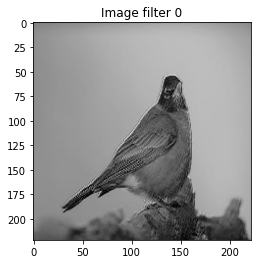

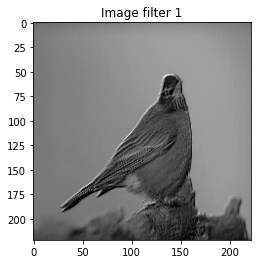

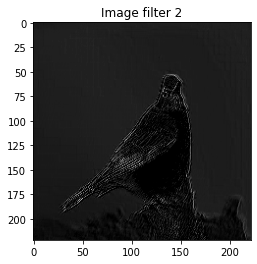

In [93]:
for i in range(num_filter):
    # plot filter channel in grayscale
    plt.figure()
    plt.title("Image filter " + str(i))
    plt.imshow(feature_maps[0, :, :, i], cmap='gray')
# show the figure
plt.show()

# Feature extraction (multiple convolutional layer)

1. Load image

In [80]:
img = load_img('/content/bird.jpg', target_size=(224, 224))

2. Create model with multiple convolutional layer

In [81]:
model = models.Sequential()
model.add(keras.Input(shape=(224, 224, 3)))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(12, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 222, 222, 4)       112       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 4)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 109, 109, 8)       296       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 8)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 52, 52, 12)        876       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 26, 12)        0         
Total params: 1,284
Trainable params: 1,284
Non-trainable params: 0
___________________________________________________

3. Get convolutional layer of model

In [82]:
ixs = []
layers_name = []
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    ixs.append(i)
    layers_name.append(layer.name)
    #print(i, layer.name, layer.output.shape)

print(ixs)
print(layers_name)

[0, 2, 4]
['conv2d_19', 'conv2d_20', 'conv2d_21']


4. Show weight of filter (kernel)

    => Follow part "Feature extraction single convolutional layer"

5. Rebuild model with parameter output that corresponding to number of convolutional layer

In [83]:
outputs = [model.layers[i].output for i in ixs]
print(model.inputs)
print(outputs)

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_7')>]
[<KerasTensor: shape=(None, 222, 222, 4) dtype=float32 (created by layer 'conv2d_19')>, <KerasTensor: shape=(None, 109, 109, 8) dtype=float32 (created by layer 'conv2d_20')>, <KerasTensor: shape=(None, 52, 52, 12) dtype=float32 (created by layer 'conv2d_21')>]


In [84]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=outputs)
model.summary()
print(model)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 222, 222, 4)       112       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 4)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 109, 109, 8)       296       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 8)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 52, 52, 12)        876       
Total params: 1,284
Trainable params: 1,284
Non-trainable params: 0
_________________________________________________________

6. Process image through convolutional layer

In [85]:
# load the image with the required shape
img = load_img('/content/bird.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# get feature map for first hidden layer
feature_maps = model.predict(img)
print("There are " + str(len(feature_maps)) + " feature map after processed through model (corresponding to " + \
      str(len(outputs)) + " convolutional layer output)")

There are 3 feature map after processed through model (corresponding to 3 convolutional layer output)


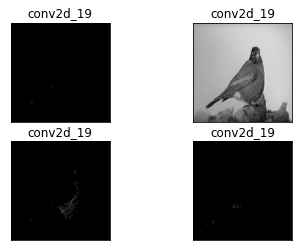

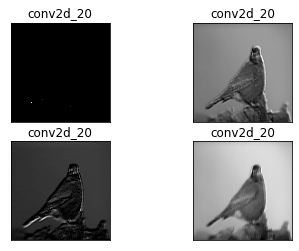

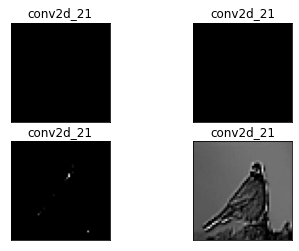

In [86]:
# Modify square depending smallest number of filter of convolutional layer in model.
# This example use 3 filter: Conv2D(4, ...), Conv2D(8, ...) and Conv2D(12, ...). So square = 4/2 = 2.

# We can see that the feature maps closer to the input of the model capture a lot of fine detail in the image and 
# that as we progress deeper into the model, the feature maps show less and less detail.

square = 2
for idx,fmap in enumerate(feature_maps):
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_title(layers_name[idx])
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    plt.show()